# Introduction

In this lab, we will learn about selecting the best hyperparameter alpha for Lasso regression models. Two approaches will be discussed: (1) selecting the optimal value of alpha by only using the training set and some information criterion, and (2) selecting the best hyperparameter using cross-validation. We will use the diabetes dataset in this example.

# Dataset

First, we will load the diabetes dataset using the **load_diabetes** function from **sklearn.datasets**. The dataset consists of 10 baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements, and a quantitative measure of disease progression one year after baseline.

In [1]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


# Adding Random Features

We will add some random features to the original data to better illustrate the feature selection performed by the Lasso model. Random features will be generated using the **RandomState** function from **numpy**

In [2]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(42)
n_random_features = 14
X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f'random_{i:02d}' for i in range(n_random_features)],
)
X = pd.concat([X, X_random], axis=1)
X[X.columns[::3]].head()

,age,bp,s3,s6,random_02,random_05,random_08,random_11
0,0.038076,0.021872,-0.043401,-0.017646,0.647689,-0.234137,-0.469474,-0.465730
1,-0.001882,-0.026328,0.074412,-0.092204,-1.012831,-1.412304,0.067528,0.110923
2,0.085299,-0.005670,-0.032356,-0.025930,-0.601707,-1.057711,0.208864,0.196861
3,-0.089063,-0.036656,-0.036038,-0.009362,-1.478522,1.057122,0.324084,0.611676
4,0.005383,0.021872,0.008142,-0.046641,0.331263,-0.185659,0.812526,1.003533


# Selecting Lasso via an Information Criterion

We will use the **LassoLarsIC** function from **sklearn.linear_model** to provide a Lasso estimator that uses the Akaike information criterion (AIC) or the Bayes information criterion (BIC) to select the optimal value of the regularization parameter alpha. We will first fit a Lasso model with the AIC criterion.

In [3]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline

start = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion='aic')).fit(X, y)
fit_time = time.time() - start

# Storing Results and Checking Optimal Alpha

We will store the AIC metric for each value of alpha used during **fit**. We will then perform the same analysis using the BIC criterion. Finally, we will check which value of **alpha** leads to the minimum AIC and BIC.

In [13]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
45.160030,5244.764779,5244.764779
42.300343,5212.341949,5212.341949
21.542052,4936.201520,4936.201520
15.034077,4881.952289,4881.952289
6.189631,4831.802601,4831.802601
5.329616,4830.880191,4830.880191
4.306012,4828.121351,4828.121351
4.124225,4832.765671,4832.765671
3.820705,4836.352124,4836.352124


# Plotting AIC and BIC Values

Finally, we will plot the AIC and BIC values for the different alpha values. The vertical lines in the plot correspond to the alpha chosen for each criterion. The selected alpha corresponds to the minimum of the AIC or BIC criterion.

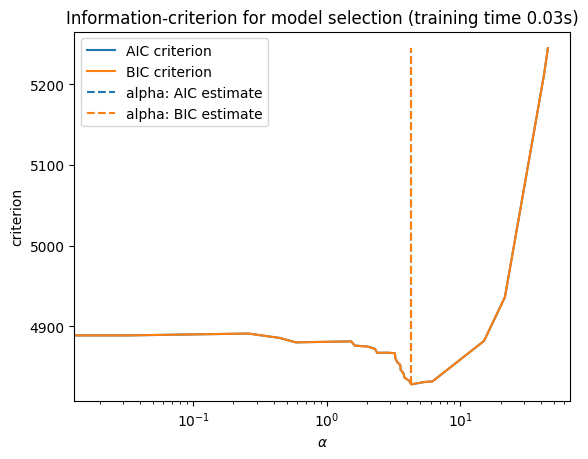

In [15]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)

# Selecting Lasso via Cross-Validation

We will use two different estimators to select the best hyperparameter alpha with integrated cross-validation: **LassoCV** and **LassoLarsCV**. For both algorithms, we will use a 20-fold cross-validation strategy.

# Lasso via Coordinate Descent

We will make the hyperparameter tuning using **LassoCV**.

In [10]:
from sklearn.linear_model import LassoCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

# Lasso via Least Angle Regression

We will make the hyperparameter tuning using **LassoLarsCV**.

In [11]:
from sklearn.linear_model import LassoLarsCV

start_time = time.time()
model = make_pipeline(StandardScaler(), LassoLarsCV(cv=20)).fit(X, y)
fit_time = time.time() - start_time

# Summary of Cross-Validation Approach

Both algorithms give roughly the same results. Lars computes a solution path only for each kink in the path. As a result, it is very efficient when there are only of few kinks, which is the case if there are few features or samples. On the opposite, coordinate descent computes the path points on a pre-specified grid (here we use the default). Thus it is more efficient if the number of grid points is smaller than the number of kinks in the path. Such a strategy can be interesting if the number of features is really large and there are enough samples to be selected in each of the cross-validation fold. In terms of numerical errors, for heavily correlated variables, Lars will accumulate more errors, while the coordinate descent algorithm will only sample the path on a grid.